In [1]:
import os
import random
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, sampler, Dataset, TensorDataset
from torchsummary import summary
import numpy as np
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [3]:
set_random_seed(0)

In [4]:
SAVE_DIR = './models'


def generate_save_dir(model_name: str, show_path: bool = True):
    """模型保存路径

    Args:
        model_name (str): 模型名称.
        show_path (bool, optional): 是否打印路径名. 默认为 True.

    Returns:
        str: 模型保存的路径.
    """
    model_path = os.path.join(SAVE_DIR, model_name)
    if show_path:
        print("models will be saved at: ", model_path)
    return model_path

In [5]:
DATA_DIR = './data'

NUM_TRAIN = 49000

transform_train = T.Compose([
    # T.ColorJitter(0.5),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 128

# 训练集
cifar10_train = dset.CIFAR10(root=DATA_DIR, train=True, download=True, transform=transform_train)
loader_train = DataLoader(cifar10_train, batch_size=batch_size,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# 验证集
cifar10_val = dset.CIFAR10(root=DATA_DIR, train=True, download=True, transform=transform_train)
loader_val = DataLoader(cifar10_val, batch_size=batch_size,
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

# 测试集
cifar10_test = dset.CIFAR10(root=DATA_DIR, train=False, download=True, transform=transform_test)
loader_test = DataLoader(cifar10_test, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [6]:
from modules.demo import ResNet9

model = ResNet9()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, verbose=True)

In [7]:
summary(model.to(device='cuda'), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
       BatchNorm2d-5          [-1, 128, 32, 32]             256
              ReLU-6          [-1, 128, 32, 32]               0
         MaxPool2d-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

In [8]:
from tools.train import train

best_model, train_loss_history, train_acc_history, val_acc_history = train(
    model, criterion, optimizer, lr_scheduler, loader_train, loader_val,
    epochs=20, save_dir=generate_save_dir('demo.pth', False)
)

 |##################################################| 100.0% Iter 350, loss = 0.8771
Epoch 1 / 20	train_acc = 0.5618, val_acc = 0.7390
 |##################################################| 100.0% Iter 350, loss = 0.7493
Epoch 2 / 20	train_acc = 0.7397, val_acc = 0.6990
 |##################################################| 100.0% Iter 350, loss = 0.4300
Epoch 3 / 20	train_acc = 0.8020, val_acc = 0.7420
 |##################################################| 100.0% Iter 350, loss = 0.4488
Epoch 4 / 20	train_acc = 0.8309, val_acc = 0.8140
 |##################################################| 100.0% Iter 350, loss = 0.4607
Epoch 5 / 20	train_acc = 0.8527, val_acc = 0.8500
 |##################################################| 100.0% Iter 350, loss = 0.2725
Epoch 6 / 20	train_acc = 0.8687, val_acc = 0.8110
 |##################################################| 100.0% Iter 350, loss = 0.3207
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.
Epoch 7 / 20	train_acc = 0.8819, val_acc = 

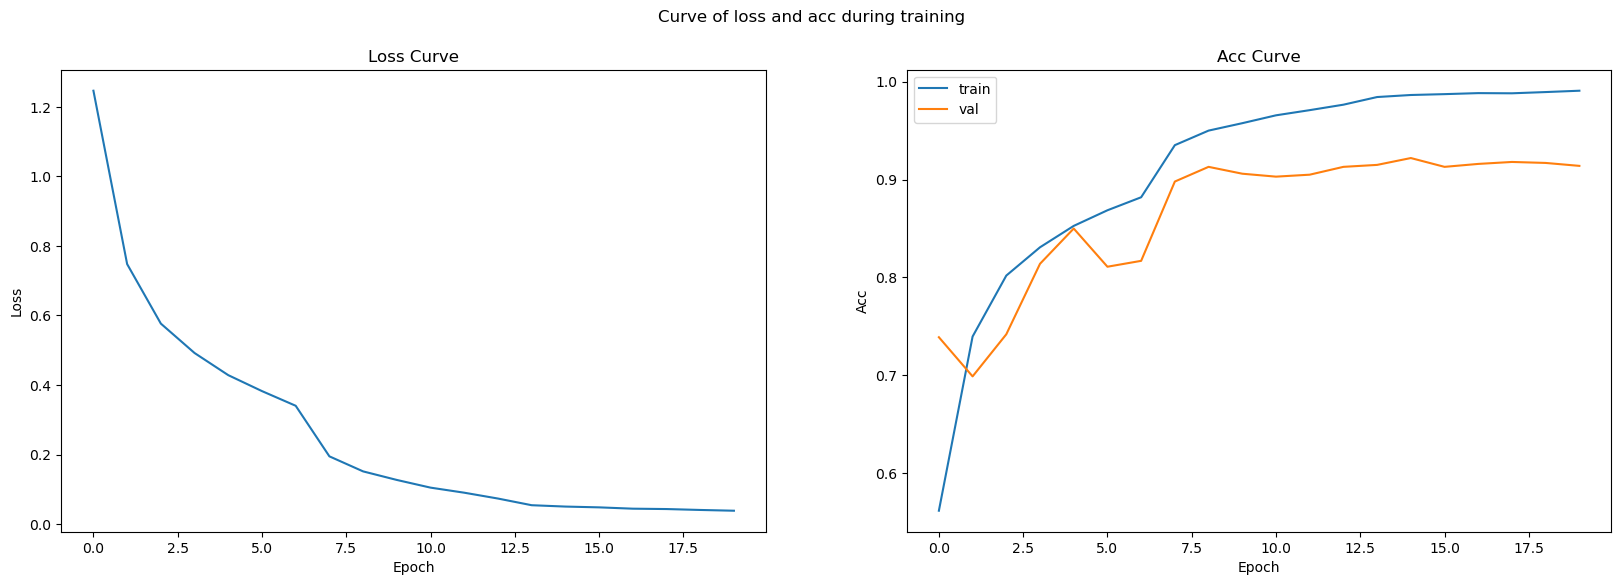

In [9]:
x_points = np.array(range(len(train_loss_history)), dtype=int)
plt.figure(figsize=(20, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(x_points, train_loss_history, '-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')

# Acc plot
plt.subplot(1, 2, 2)
plt.plot(x_points, train_acc_history, '-', label='train')
plt.plot(x_points, val_acc_history, '-', label='val')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Acc Curve')
plt.legend()

plt.suptitle('Curve of loss and acc during training')
plt.show()

In [10]:
from tools.test import check_accuracy

_ = check_accuracy(best_model, loader_test)

Checking accuracy on test set
Got 9128 / 10000 correct (91.28)
Class	Accuracy
----------------
plane 	 |  93.9
car   	 |  96.7
bird  	 |  87.4
cat   	 |  82.3
deer  	 |  90.9
dog   	 |  86.1
frog  	 |  93.1
horse 	 |  93.5
ship  	 |  94.6
truck 	 |  94.3


In [11]:
from modules.vgg import vgg13_bn

model = vgg13_bn(pretrained=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, verbose=True)

Downloading: "https://download.pytorch.org/models/vgg13_bn-abd245e5.pth" to /home/asuna/.cache/torch/hub/checkpoints/vgg13_bn-abd245e5.pth
4.6%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

17.3%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

30.1%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub

In [12]:
best_model, train_loss_history, train_acc_history, val_acc_history = train(
    model, criterion, optimizer, lr_scheduler, loader_train, loader_val,
    epochs=20, save_dir=generate_save_dir('vgg.pth', False)
)

 |##################################################| 100.0% Iter 350, loss = 0.6099
Epoch 1 / 20	train_acc = 0.7710, val_acc = 0.8000
 |##################################################| 100.0% Iter 350, loss = 0.4691
Epoch 2 / 20	train_acc = 0.8557, val_acc = 0.8380
 |##################################################| 100.0% Iter 350, loss = 0.4044
Epoch 3 / 20	train_acc = 0.8833, val_acc = 0.8220
 |##################################################| 100.0% Iter 350, loss = 0.3863
Epoch 4 / 20	train_acc = 0.8987, val_acc = 0.8590
 |##################################################| 100.0% Iter 350, loss = 0.4293
Epoch 5 / 20	train_acc = 0.9123, val_acc = 0.8570
 |##################################################| 100.0% Iter 350, loss = 0.2231
Epoch 6 / 20	train_acc = 0.9221, val_acc = 0.8650
 |##################################################| 100.0% Iter 350, loss = 0.1872
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.
Epoch 7 / 20	train_acc = 0.9291, val_acc = 

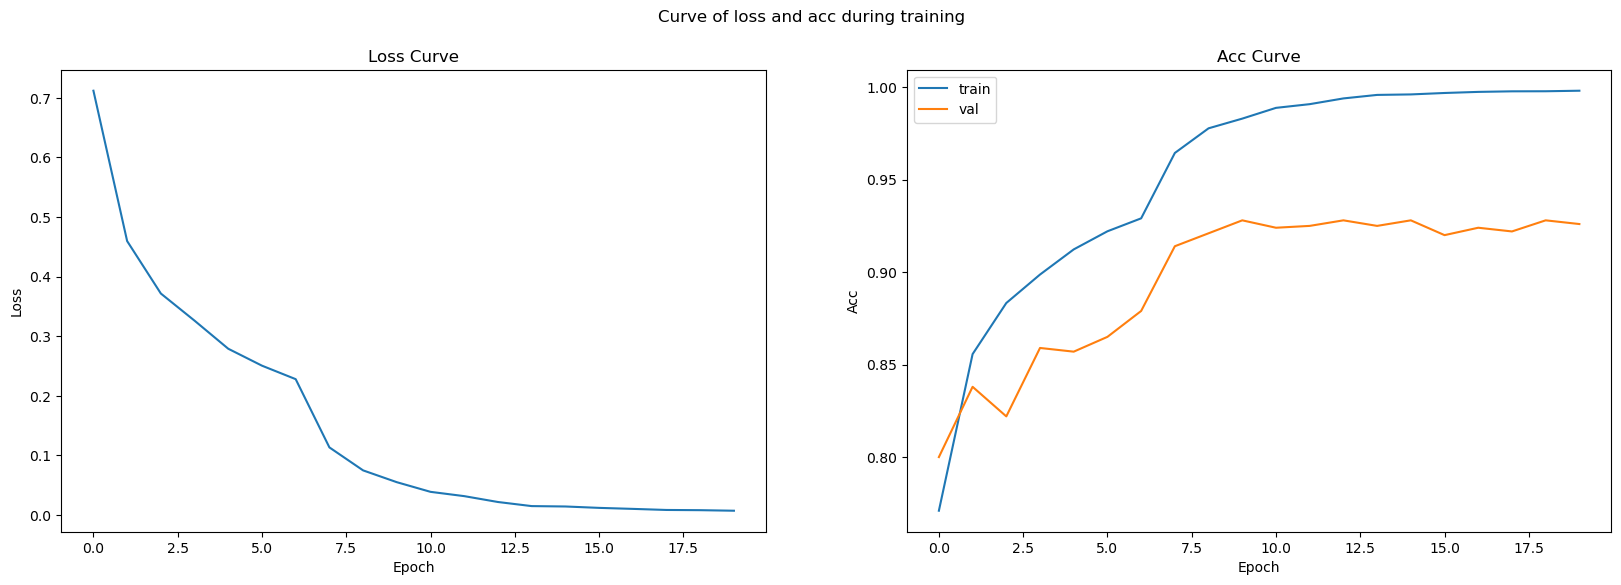

In [13]:
x_points = np.array(range(len(train_loss_history)), dtype=int)
plt.figure(figsize=(20, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(x_points, train_loss_history, '-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')

# Acc plot
plt.subplot(1, 2, 2)
plt.plot(x_points, train_acc_history, '-', label='train')
plt.plot(x_points, val_acc_history, '-', label='val')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Acc Curve')
plt.legend()

plt.suptitle('Curve of loss and acc during training')
plt.show()

In [14]:
_ = check_accuracy(best_model, loader_test)

Checking accuracy on test set
Got 9194 / 10000 correct (91.94)
Class	Accuracy
----------------
plane 	 |  93.5
car   	 |  96.1
bird  	 |  89.2
cat   	 |  82.8
deer  	 |  93.9
dog   	 |  87.4
frog  	 |  94.4
horse 	 |  93.1
ship  	 |  95.6
truck 	 |  93.4


In [15]:
from modules.resnet import resnet50

model = resnet50(pretrained=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, verbose=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/asuna/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
24.0%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [16]:
best_model, train_loss_history, train_acc_history, val_acc_history = train(
    model, criterion, optimizer, lr_scheduler, loader_train, loader_val,
    epochs=20, save_dir=generate_save_dir('resnet.pth', False)
)

 |##################################################| 100.0% Iter 350, loss = 0.7959
Epoch 1 / 20	train_acc = 0.6502, val_acc = 0.7180
 |##################################################| 100.0% Iter 350, loss = 0.5072
Epoch 2 / 20	train_acc = 0.7937, val_acc = 0.7970
 |##################################################| 100.0% Iter 350, loss = 0.4995
Epoch 3 / 20	train_acc = 0.8337, val_acc = 0.8130
 |##################################################| 100.0% Iter 350, loss = 0.4019
Epoch 4 / 20	train_acc = 0.8567, val_acc = 0.8330
 |##################################################| 100.0% Iter 350, loss = 0.3477
Epoch 5 / 20	train_acc = 0.8731, val_acc = 0.8370
 |##################################################| 100.0% Iter 350, loss = 0.3249
Epoch 6 / 20	train_acc = 0.8834, val_acc = 0.8580
 |##################################################| 100.0% Iter 350, loss = 0.3129
Epoch 00007: reducing learning rate of group 0 to 1.0000e-04.
Epoch 7 / 20	train_acc = 0.8923, val_acc = 

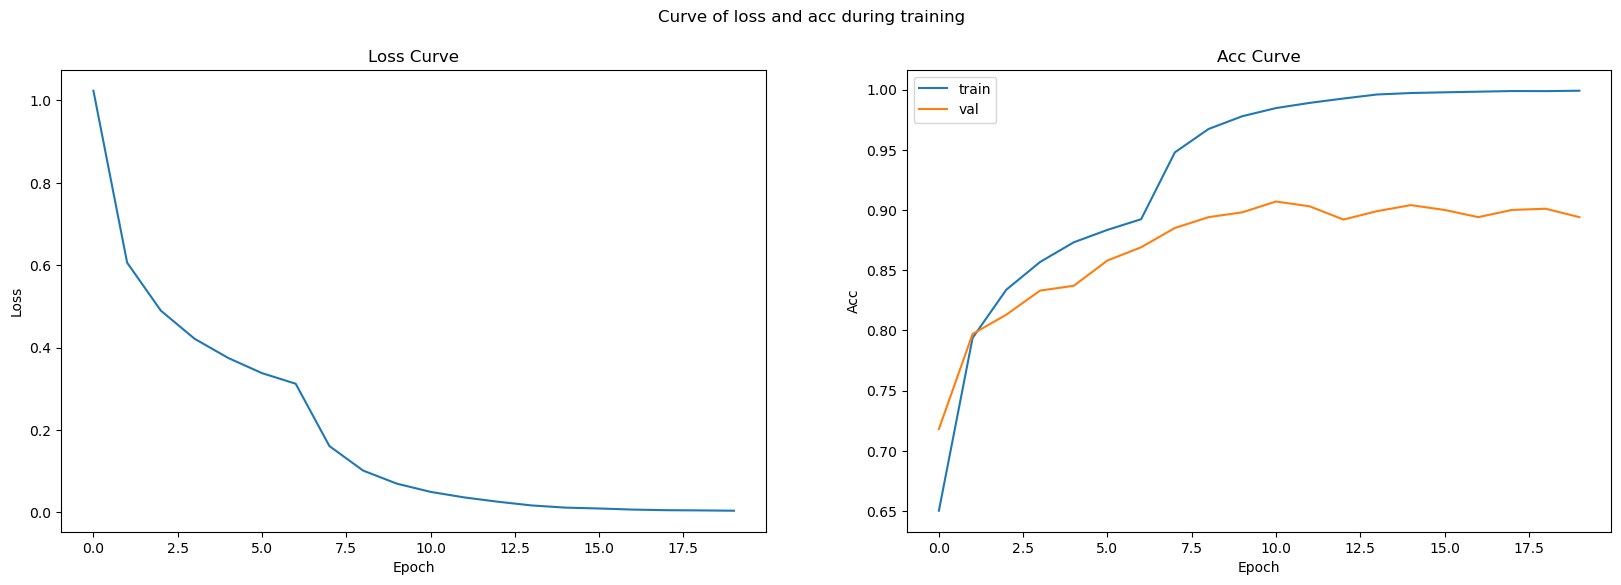

In [17]:
x_points = np.array(range(len(train_loss_history)), dtype=int)
plt.figure(figsize=(20, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(x_points, train_loss_history, '-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')

# Acc plot
plt.subplot(1, 2, 2)
plt.plot(x_points, train_acc_history, '-', label='train')
plt.plot(x_points, val_acc_history, '-', label='val')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Acc Curve')
plt.legend()

plt.suptitle('Curve of loss and acc during training')
plt.show()

In [18]:
_ = check_accuracy(best_model, loader_test)

Checking accuracy on test set
Got 8935 / 10000 correct (89.35)
Class	Accuracy
----------------
plane 	 |  92.3
car   	 |  96.4
bird  	 |  83.3
cat   	 |  76.0
deer  	 |  91.9
dog   	 |  82.6
frog  	 |  93.3
horse 	 |  91.9
ship  	 |  93.4
truck 	 |  92.4
